# 机器学习与量化策略


https://blog.csdn.net/weixin_46277779/article/details/128442624

机器学习在量化投资策略中的应用

https://www.ainumeric.com/article/ml_finance.php

分层聚类

https://medium.com/@orenji.eirl/hierarchical-risk-parity-with-python-and-riskfolio-lib-c0e60b94252e

In [1]:
import sqlite3
import pandas as pd  
import talib
from datetime import datetime
import backtrader as bt
import matplotlib.pyplot as plt
import akshare as ak
import numpy as np
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
%matplotlib inline   

#正常显示画图时出现的中文和负号
from pylab import mpl

mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False

In [111]:
sns.__version__

'0.12.2'

In [2]:
# 读取全量数据
def read_hq():
    
    conn=sqlite3.connect(r'F:\BaiduNetdiskDownload\stock_2018_daily\stock_2018.db')
    #stock_daily=pd.read_sql("select * from stock_daily",con=conn)
    stock_daily=pd.read_sql("select * from stock_daily where 股票代码>'003000.SZ'",con=conn)

    stock_daily.columns=['index', 'date', '股票代码', '股票简称', 'open', 'high', 'low', 'close', 'volume',
           '成交额(千元)', '换手率(%)', '量比', '市盈率(静态)', '市盈率(TTM)', '市盈率(动态)', '市净率',
           '市销率', '市销率(TTM)', '股息率(%)', '股息率(TTM)(%)', '总股本(万股)', '流通股本(万股)',
           '总市值(万元)', '流通市值(万元)']
    stock_daily["date"]=stock_daily["date"].astype("str").astype("datetime64[ns]")
    stock_daily.set_index("date",inplace=True,drop=False)
    stock_daily.index.names = ['date_index']
    stock_daily["openinterest"]=0
    return stock_daily

#从全量数据中抽取个别股票数据
def get_data_1(syboml,time,stock_d):
    stock=stock_d[stock_d["股票代码"]==syboml][["open","high","low","close","volume","openinterest"]]
    stock=pd.concat([stock,time],axis=1).fillna(method="bfill").fillna(method="ffill")
    #stock=pd.concat([stock,time],axis=1).fillna(-1)#对每只股票缺失的交易日进行补齐
    return stock[["open","high","low","close","volume","openinterest"]]


#定义单个交易日中的策略
class my_strategy_date_2(bt.Strategy):
    #全局设定交易策略的参数
    cash_value={}
    params = (
        ("sell_d",{}),("buy_d",{})  # 注意要有逗号！！
    )

    def __init__(self):
        # 初始化交易指令、买卖价格和手续费
        self.order = None

    #单个交易日中的策略：先比较当天是否在买入或者卖出的日期中，如果在就获取日期对应的股票列表进行买卖操作
    def next(self):
        # 检查是否持仓 
        #print(str(self.datetime.date(0)))
        self.cash_value.update({str(self.datetime.date(0)):self.broker.getvalue()})#记录持仓
        if str(self.datetime.date(0)) in self.params.sell_d.keys(): # 卖出目标股票
            s_list=self.params.sell_d[str(self.datetime.date(0))]
            for i in s_list:
                self.order_target_percent(target=0,data=i)
        if str(self.datetime.date(0)) in self.params.buy_d.keys(): # 买入目标股票
            s_list=self.params.buy_d[str(self.datetime.date(0))]
            for i in s_list:
                self.order_target_percent(target=0.9/len(s_list),data=i)
                

    # 下面两个函数log与notify_order都是为了在交易过程中输出交易记录和其他信息        
    def log(self, txt, dt=None):
        ''' 输出日志'''
        dt = dt or self.datas[0].datetime.date(0) # 拿现在的日期
        print('%s, %s' % (dt.isoformat(), txt))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed, order.Canceled, order.Margin]:
            if order.isbuy():
                self.log(f"""买入{order.data._name}, 成交量{order.executed.size}，成交价{order.executed.price:.2f}""")
            elif order.issell():
                self.log(f"""卖出{order.data._name}, 成交量{order.executed.size}，成交价{order.executed.price:.2f}""")
            self.bar_executed = len(self)

        # Write down: no pending order
        self.order = None

#读入策略并在所有交易日执行
def huice_run_num(start,end,buy_date,sell_date,stock_daily_x,stock_list,strategy):

    #实例化一个交易程序
    cerebro = bt.Cerebro()

    #把所有涉及到的股票数据塞入交易程序
    time_jy=pd.Series(range(0,len(stock_daily_x.date.unique())),index=stock_daily_x.date.unique()).sort_index()#构建包含所有交易日的序列
    for i in stock_list:#逐个输入涉及到的所有股票数据
        stock=get_data_1(i,time_jy,stock_daily_x)
        data = bt.feeds.PandasData(dataname=stock,fromdate=start,todate=end)           
        cerebro.adddata(data,name=i) 
    
    #交易程序读入对应策略
    cerebro.addstrategy(strategy,sell_d=sell_date,buy_d=buy_date) 
    cerebro.broker.setcash(1000000) #定义初始金额
    cerebro.broker.setcommission(commission=0.002)#定义佣金


    #下面是数据交易完成后的相关评估参数
    print(start.date(),end.date())
    print('初始资金: %.2f' % cerebro.broker.getvalue())
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name = 'SharpeRatio')#获得夏普率
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='DW')#获得回撤
    results = cerebro.run()
    strat = results[0]
    print('最终资金: %.2f' % cerebro.broker.getvalue())
    print('夏普比率:', strat.analyzers.SharpeRatio.get_analysis())
    print('回撤指标:', strat.analyzers.DW.get_analysis())
    
    return strategy.cash_value #这是累计收益数据，如果需要自己作图可以用这个
    #return cerebro

In [3]:
conn=sqlite3.connect(r'F:\BaiduNetdiskDownload\stock_2018_daily\stock_2018.db')
stock_ml=pd.read_sql("select * from stock_daily where 股票代码>'003000.SZ' and 交易日期>'20220217'",con=conn)
stock_ml.columns=['index', 'date', '股票代码', '股票简称', 'open', 'high', 'low', 'close', 'volume',
           '成交额(千元)', '换手率(%)', '量比', '市盈率(静态)', '市盈率(TTM)', '市盈率(动态)', '市净率',
           '市销率', '市销率(TTM)', '股息率(%)', '股息率(TTM)(%)', '总股本(万股)', '流通股本(万股)',
           '总市值(万元)', '流通市值(万元)']

## 量化策略机器学习的特征工程


### 和财务数据结合的指标

In [118]:
stock_ml[['市盈率(静态)', '市盈率(TTM)', '市盈率(动态)', '市净率',
           '市销率', '市销率(TTM)', '股息率(%)', '股息率(TTM)(%)', '总股本(万股)', '流通股本(万股)',
           '总市值(万元)', '流通市值(万元)']]

,市盈率(静态),市盈率(TTM),市盈率(动态),市净率,市销率,市销率(TTM),股息率(%),股息率(TTM)(%),总股本(万股),流通股本(万股),总市值(万元),流通市值(万元)
0,32.2803,36.8533,33.13,2.4649,2.8900,2.4182,1.0720,1.0720,12792.6796,4760.4331,326341.2566,121438.6484
1,32.7485,37.3878,33.61,2.5006,2.9319,2.4533,1.0567,1.0567,12792.6796,4760.4331,331074.5480,123200.0086
2,30.6227,34.9608,31.43,2.3383,2.7416,2.2940,1.1300,1.1300,12792.6796,4760.4331,309582.8463,115202.4810
3,30.0153,34.2673,30.81,2.2919,2.6872,2.2485,1.1529,1.1529,12792.6796,4760.4331,303442.3601,112917.4731
4,28.2184,32.2159,28.96,2.1547,2.5263,2.1139,1.2263,1.2263,12792.6796,4760.4331,285276.7551,106157.6581
...,...,...,...,...,...,...,...,...,...,...,...,...
295498,NaN,NaN,NaN,18.0001,66.0434,48.3345,NaN,NaN,25771.8203,18592.2790,375495.4218,270889.5050
295499,NaN,NaN,NaN,18.1360,66.5420,48.6994,NaN,NaN,25771.8203,18592.2790,378330.3220,272934.6557
295500,NaN,NaN,NaN,18.0865,66.3607,48.5667,NaN,NaN,25771.8203,18592.2790,377299.4492,272190.9646
295501,NaN,NaN,NaN,17.7283,65.0462,47.6047,NaN,NaN,25771.8203,18592.2790,369825.6213,266799.2037


### 行情指标的衍生量及其简单衍生

In [119]:
stock_ml[['open', 'high', 'low', 'close', 'volume','成交额(千元)', '换手率(%)', '量比',]]

,open,high,low,close,volume,成交额(千元),换手率(%),量比
0,32.6465,34.1911,32.2930,33.3926,82179.77,208401.562,17.2631,0.62
1,33.0653,34.2958,33.0653,33.8769,72040.19,186218.296,15.1331,0.62
2,33.5497,33.8507,31.4814,31.6778,88041.47,216759.706,18.4944,0.86
3,32.0181,32.0574,30.8139,31.0495,66636.33,158948.212,13.9980,0.70
4,30.9448,31.4553,28.6540,29.1907,83206.15,191270.818,17.4787,0.98
...,...,...,...,...,...,...,...,...
295498,6161.7118,6395.8655,6161.7118,6317.8143,9090.62,13245.225,0.4889,0.98
295499,6330.8228,6365.5122,6287.4610,6365.5122,4324.41,6313.445,0.2326,0.48
295500,6339.4952,6408.8740,6339.4952,6348.1675,2639.02,3886.946,0.1419,0.31
295501,6326.4866,6391.5293,6183.3927,6222.4183,4853.73,6999.374,0.2611,0.65


In [120]:
stock_ml["close"]-stock_ml["open"]

0           0.7461
1           0.8116
2          -1.8719
3          -0.9686
4          -1.7541
            ...   
295498    156.1025
295499     34.6894
295500      8.6723
295501   -104.0683
295502    -43.3618
Length: 295503, dtype: float64

In [121]:
stock_ml["high"]-stock_ml["low"]

0           1.8981
1           1.2305
2           2.3693
3           1.2435
4           2.8013
            ...   
295498    234.1537
295499     78.0512
295500     69.3788
295501    208.1366
295502    117.0768
Length: 295503, dtype: float64

### 基于talib的股价数据衍生

* talib

TA-Lib，全称“Technical Analysis Library”, 即技术分析库，是Python金融量化的高级库，涵盖了150多种股票、期货交易软件中常用的技术分析指标，如MACD、RSI、KDJ、动量指标、布林带等等。TA-Lib可分为10个子板块：Overlap Studies(重叠指标)，Momentum Indicators(动量指标)，Volume Indicators(交易量指标)，Cycle Indicators(周期指标)，Price Transform(价格变换)，Volatility Indicators(波动率指标)，Pattern Recognition(模式识别)，Statistic Functions(统计函数)，Math Transform(数学变换)和Math Operators(数学运算)，

链接：https://www.jianshu.com/p/7ecc7962d638

TA-LIB 200多个技术指标含有及计算式:

https://blog.csdn.net/MARY197011111/article/details/79622184

重叠指标

https://www.jianshu.com/p/7ecc7962d638


In [5]:
df

,A,B,C,D
0,foo,one,1,2.0
1,bar,one,5,5.0
2,foo,two,5,8.0
3,bar,three,2,1.0
4,foo,two,5,2.0
5,bar,two,5,9.0
6,foo,one,6,4.0
7,foo,three,7,6.0


In [10]:
#group_keys的作用
df = pd.DataFrame({
    'A': ['foo', 'bar', 'foo', 'bar', 'foo', 'bar', 'foo', 'foo'],
    'B': ['one', 'one', 'two', 'three', 'two', 'two', 'one', 'three'],
    'C': [1, 5, 5, 2, 5, 5, 6, 7],
    'D': [2.0, 5., 8., 1., 2., 9., 4., 6.]
})
 
# 自定义函数，用于计算每个分组的平均C列和D列的和
def custom_func(x):
    return x
 
# 使用groupby应用自定义函数
grouped = df.groupby('A', group_keys=False).apply(custom_func)
 
grouped

,A,B,C,D
0,foo,one,1,2.0
1,bar,one,5,5.0
2,foo,two,5,8.0
3,bar,three,2,1.0
4,foo,two,5,2.0
5,bar,two,5,9.0
6,foo,one,6,4.0
7,foo,three,7,6.0


In [4]:
def get_factor(x):
    mean_5=talib.SMA(x.close,5)
    mean_10=talib.SMA(x.close,10)
    
    MACDx,MACDy,MACDz=talib.MACD(x.close,fastperiod=12, slowperiod=26, signalperiod=9)
    
    dong10=talib.MOM(x.close, timeperiod=10)
    rsi_6=talib.RSI(x.close, timeperiod=6)
    rsi_24=talib.RSI(x.close, timeperiod=24)
    up = talib.MAX(x.close, 20)
    down = talib.MIN(x.close, 20)
    Bupper,Bmiddle,Blower=talib.BBANDS(x.close,matype=talib.MA_Type.T3)
    
    return_5=x.close.pct_change(5)
    return_10=x.close.pct_change(10)
    return_10_shift=return_10.shift(-10)
    
    df=pd.concat([mean_5,mean_10,MACDx,MACDy,MACDz,dong10,rsi_6,rsi_24,up,down,Bupper,Bmiddle,Blower,return_5,return_10,return_10_shift],axis=1)
    df.columns=["mean_5","mean_10","MACDx","MACDy","MACDz","dong10","rsi_6","rsi_24","up","down","Bupper","Bmiddle","Blower","return_5","return_10","return_10_shift"]

    return df
    #mean_10=talib.SMA(x.close,10)

In [5]:
z1=stock_ml.groupby('股票代码', group_keys=False).apply(get_factor)
stock_ml_j=stock_ml.join(z1)

In [6]:
stock_ml_j["close-o"]=stock_ml_j["close"]-stock_ml_j["open"]
stock_ml_j["high-l"]=stock_ml_j["high"]-stock_ml_j["low"]

In [29]:
stock_ml_j.columns

Index(['index', 'date', '股票代码', '股票简称', 'open', 'high', 'low', 'close',
       'volume', '成交额(千元)', '换手率(%)', '量比', '市盈率(静态)', '市盈率(TTM)', '市盈率(动态)',
       '市净率', '市销率', '市销率(TTM)', '股息率(%)', '股息率(TTM)(%)', '总股本(万股)',
       '流通股本(万股)', '总市值(万元)', '流通市值(万元)', 'mean_5', 'mean_10', 'MACDx',
       'MACDy', 'MACDz', 'dong10', 'rsi_6', 'rsi_24', 'up', 'down', 'Bupper',
       'Bmiddle', 'Blower', 'return_5', 'return_10', 'return_10_shift',
       'close-o', 'high-l'],
      dtype='object')

In [12]:
stock_ml.columns

Index(['index', 'date', '股票代码', '股票简称', 'open', 'high', 'low', 'close',
       'volume', '成交额(千元)', '换手率(%)', '量比', '市盈率(静态)', '市盈率(TTM)', '市盈率(动态)',
       '市净率', '市销率', '市销率(TTM)', '股息率(%)', '股息率(TTM)(%)', '总股本(万股)',
       '流通股本(万股)', '总市值(万元)', '流通市值(万元)'],
      dtype='object')

### 目标向量的构建

In [7]:
stock_ml_j["return_10_shift01"]=stock_ml_j["return_10_shift"].apply(lambda x:1 if x>0 else 0)
stock_ml_j["return_10_shift_rank"]=stock_ml_j.groupby("date").return_10_shift.rank(pct=True)

In [11]:
s_x=stock_ml_j[['open', 'high', 'low', 'close',
       'volume', '成交额(千元)', '换手率(%)', '量比', '市盈率(静态)', '市盈率(TTM)', '市盈率(动态)',
       '市净率', '市销率', '市销率(TTM)', '股息率(%)', '股息率(TTM)(%)', '总股本(万股)',
       '流通股本(万股)', '总市值(万元)', '流通市值(万元)', 'mean_5', 'mean_10', 'MACDx',
       'MACDy', 'MACDz', 'dong10', 'rsi_6', 'rsi_24', 'up', 'down', 'Bupper',
       'Bmiddle', 'Blower', 'return_5', 'return_10', 'return_10_shift',
       'close-o', 'high-l', 'return_10_shift01', 'return_10_shift_rank']].dropna()

In [34]:
s_x

,open,high,low,close,volume,成交额(千元),换手率(%),量比,市盈率(静态),市盈率(TTM),...,Bupper,Bmiddle,Blower,return_5,return_10,return_10_shift,close-o,high-l,return_10_shift01,return_10_shift_rank
33,25.4993,27.7246,25.2244,27.7246,34246.31,70810.083,7.1939,1.13,26.8012,30.5979,...,27.649849,25.494994,23.340138,0.083373,0.046958,-0.177525,2.2253,2.5002,0,0.160684
34,30.4735,30.4997,28.4838,28.6671,185686.60,423791.505,39.0062,5.86,27.7122,31.6380,...,29.244168,26.047536,22.850903,0.112806,0.095000,-0.232877,-1.8064,2.0159,0,0.124786
35,27.4497,28.1435,25.8004,27.7508,124222.99,254010.488,26.0949,1.97,26.8265,30.6268,...,29.422648,26.646001,23.869354,0.131268,0.050546,-0.186323,0.3011,2.3431,0,0.586177
36,27.0178,27.0963,25.2375,25.4208,101241.22,200442.507,21.2672,1.26,24.5740,28.0553,...,29.650834,26.879993,24.109152,0.000516,-0.022645,-0.093719,-1.5970,1.8588,0,0.757240
37,25.1328,25.9182,24.7401,25.6302,61332.55,118787.745,11.6759,0.65,24.7765,28.2864,...,29.383920,26.817879,24.251839,0.017144,0.021388,-0.146066,0.4974,1.1781,0,0.673765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294513,49.9198,50.0207,49.4958,49.5665,5420.12,26688.831,2.9539,0.97,27.4317,27.0383,...,49.654878,49.017886,48.380893,0.034774,0.027628,0.182280,-0.3533,0.5249,1,0.932965
294514,49.4857,49.8289,49.0516,49.7986,3945.67,19291.242,2.1503,0.74,27.5602,27.1650,...,49.921977,49.331443,48.740910,0.019004,0.032008,0.135213,0.3129,0.7773,1,0.886346
294515,49.7179,50.5961,49.7179,50.5457,6807.55,33943.259,3.7100,1.46,27.9736,27.5725,...,50.456586,49.668023,48.879459,0.033223,0.077469,0.118633,0.8278,0.8782,1,0.878453
294516,50.4750,51.0706,50.3034,50.4750,6385.14,32019.091,3.4798,1.20,27.9345,27.5339,...,50.904120,49.985911,49.067702,0.017709,0.074576,0.080000,0.0000,0.7672,1,0.877953


In [32]:
stock_ml_j.columns

Index(['index', 'date', '股票代码', '股票简称', 'open', 'high', 'low', 'close',
       'volume', '成交额(千元)', '换手率(%)', '量比', '市盈率(静态)', '市盈率(TTM)', '市盈率(动态)',
       '市净率', '市销率', '市销率(TTM)', '股息率(%)', '股息率(TTM)(%)', '总股本(万股)',
       '流通股本(万股)', '总市值(万元)', '流通市值(万元)', 'mean_5', 'mean_10', 'MACDx',
       'MACDy', 'MACDz', 'dong10', 'rsi_6', 'rsi_24', 'up', 'down', 'Bupper',
       'Bmiddle', 'Blower', 'return_5', 'return_10', 'return_10_shift',
       'close-o', 'high-l', 'return_10_shift01', 'return_10_shift_rank'],
      dtype='object')

In [143]:
len(stock_ml_j)

295503

In [12]:
#s_x=stock_ml_j[['open', 'high', 'low', 'close',
       'volume', '成交额(千元)', '换手率(%)', '量比', '市盈率(静态)', '市盈率(TTM)', '市盈率(动态)',
       '市净率', '市销率', '市销率(TTM)', '股息率(%)', '股息率(TTM)(%)', '总股本(万股)',
       '流通股本(万股)', '总市值(万元)', '流通市值(万元)', 'b_high', 'b_low', 'MACD_x',
       'MACD_y', 'MACD_z', 'dong10', 'rsi_6', 'rsi_24', 'up', 'down',
       'return_30', 'return_5', 'return_10', 'return_10_shift', 'close-o',
       'high-l', 'return_10_shift_01', 'return_10_shift_rank']].dropna()

IndentationError: unexpected indent (4152055964.py, line 2)

## 特征分析与可视化

https://seaborn.pydata.org/archive/0.11/tutorial.html

https://blog.csdn.net/qq_41185868/article/details/114041840

https://blog.csdn.net/liujingwei8610/article/details/138870627

https://blog.csdn.net/weixin_40787712/article/details/120695112

https://zhuanlan.zhihu.com/p/165940283


kind: Literal['scatter', 'kde', 'hist', 'hex', 'reg', 'resid'] = "scatter


* 分布特征

* 相关性分析

p值常见有三个标准一个是0.1，0.05，0.01；

p值取值范围是0~1，不包括0和1，通常情况下，一般有三个判断标准一个是0.01、0.05以及0.1。在绝大多数情况下，如果p值小于0.01，则说明至少有99％的把握，如果p值小于0.05（且大于或等于0.01），则说明至少有95％的把握，如果p值小于0.1（且大于或等于0.05），则说明至少有90％的把握。

在统计语言表达上，如果p值小于0.01，则称作0.01水平显著，例如，研究人员分析X对Y是否存在影响关系时，如果X对应的p值为0.00（由于小数位精度要求，展示为0.00），则说明X对Y存在影响关系这件事至少有99％的把握，统计语言描述为X在0.01水平上呈现显著性。如果P值小于0.05(且大于或等于0.01)，则称作在0.05水平上显著。

r 相关性大小意义：
|r|=1时，完全相关；
|r|≥0.8时，高度相关；
0.5≤|r|＜0.8时，中度相关；
0.3≤|r|＜0.5时，低度相关；
|r|＜0.3时，基本不相关；

#### 特征的分布

In [42]:
s_x['rsi_6'].describe()

count    135425.000000
mean         49.518487
std          18.066975
min           1.720351
25%          35.992658
50%          50.074647
75%          62.750408
max          99.784024
Name: rsi_6, dtype: float64

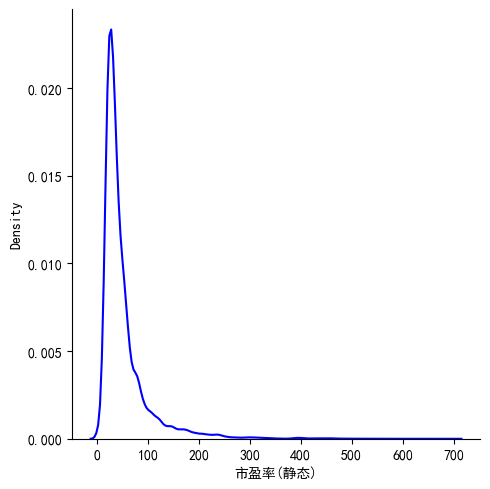

In [44]:
plot = sns.displot(s_x,x='市盈率(静态)',color='b',kind="kde")

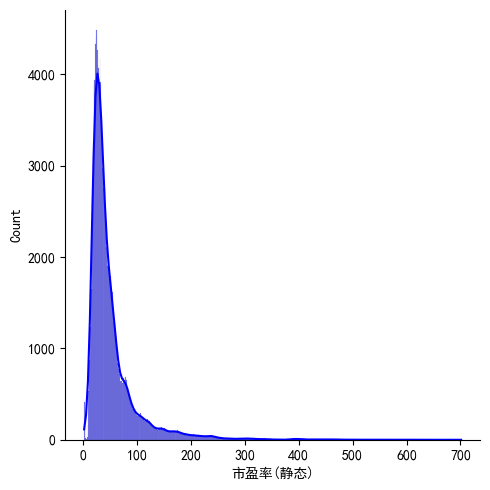

In [37]:
plot = sns.displot(s_x,x='市盈率(静态)',kde=True,color='b')

In [ ]:
s_x_s=s_x.sample(pct=0.1)

#### 相关性分析

-7.77% (0.00%)


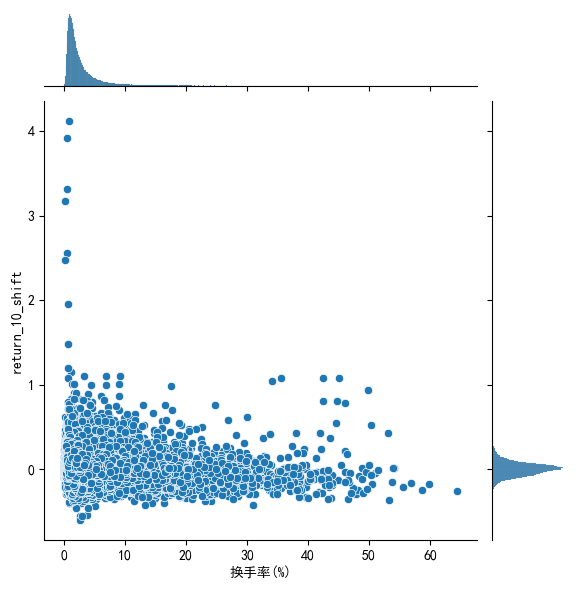

In [13]:
factor='换手率(%)'
target='return_10_shift'

j=sns.jointplot(x=factor, y=target, data=s_x,kind='scatter')
r, p = spearmanr(s_x[factor], s_x[target])
print(f'{r:,.2%} ({p:.2%})')#R为相关系数 P为对应的P值

#### 特征矩阵的多因子相关性分析

* sns.clustermap

`sns.clustermap` 是 Seaborn 库中的一个高级函数，用于生成带有层次聚类的热力图（Hierarchical Clustering Heatmap）。它的主要目的是对数据矩阵（如相关系数矩阵、表达数据等）进行可视化，并通过行和列的聚类来揭示数据内部的结构和模式。

`sns.clustermap` 的意义和特点包括：

1. **数据结构发现**：通过对数据集的行和列应用层次聚类算法（如平均链接法、单连接法、完全连接法等），`clustermap` 可以发现数据中的隐藏群体或模块，这对于探索复杂数据集中的自然分组尤为有用。

2. **热力图可视化**：以颜色编码的方式展示数据值，颜色的深浅代表数值的高低，直观地展示数据矩阵中的数值分布和强度。这对于观察变量间相对大小和模式非常有帮助。

3. **聚类指示**：通过 dendrogram（树状图）展示行和列的聚类关系，用户可以直接从图中读取哪些行（或列）被聚类在一起，从而理解数据的分组依据。

4. **交互式探索**：生成的热力图通常具有交互性（取决于使用的环境，如 Jupyter Notebook），用户可以放大、缩小或悬停查看具体的数值，便于详细分析。

5. **高级定制**：提供了丰富的参数选项，允许用户自定义颜色方案、聚类方法、距离度量、注释、图例等，以满足特定分析需求。

总的来说，`sns.clustermap` 是一个强大的数据分析和可视化工具，尤其适用于生物学（如基因表达分析）、社会科学、市场研究等领域中，需要从大规模数据集中寻找模式、相关性和分类的场景。通过同时展示数据的数值强度和结构关系，它极大地增强了数据探索和解释的能力。

* sns.PairGrid

`sns.PairGrid` 是 Seaborn 库中的一个灵活的图形接口，用于创建成对关系的子图网格，主要用于绘制数据集中所有变量两两之间的关系图。这对理解多维数据集中的变量间相互作用非常有帮助。其意义和功能主要包括：

1. **灵活的布局**：`PairGrid` 会为数据集中的每一对变量创建一个子图，你可以自定义这些子图中显示的内容，比如在非对角线位置上绘制散点图表示两个变量之间的关系，在对角线位置上显示直方图或核密度估计图来展示单个变量的分布。

2. **自定义绘图类型**：通过 `map` 或 `map_upper`, `map_lower`, `map_diag` 方法，用户可以指定在每个子图上绘制何种类型的图表，比如散点图(scatterplot)、线性回归图(regplot)、核密度图(kdeplot)等，这使得 `PairGrid` 极其灵活，能够适应多种数据分析需求。

3. **分组和着色**：通过 `hue` 参数，可以在图表中根据另一个变量对数据点进行分组和着色，这对于探索第三个变量如何影响对变量间的关系尤为重要，增加了可视化分析的维度。

4. **高级控制**：`PairGrid` 提供了对每个子图的精细控制，允许用户调整图表的各个方面，如颜色、标记样式、标签等，以更好地讲述数据故事。

简而言之，`sns.PairGrid` 的核心意义在于提供了一种机制，用于系统性地探索数据集中所有变量之间的成对关系，同时保留了高度的可定制性，使数据科学家和分析师能够深入挖掘数据中的模式和关联，特别是在探索性数据分析阶段。

* sns.jointplot

`sns.jointplot` 是 Seaborn 库中的一个功能强大的函数，用于创建联合分布图（Joint Distribution Plot）。这种图表主要用于可视化两个连续变量之间的关系，同时提供它们各自分布的概览。Jointplot 结合了散点图（展示两个变量之间的成对关系）和单变量分布的可视化（通常是直方图或核密度估计图，KDE），从而在一个图表中提供了两种变量联合及边际分布的完整视图。

`sns.jointplot` 的意义和特点包括：

1. **双变量关系展示**：通过散点图（默认类型）展示两个连续变量之间的相互关系，如相关性、聚集模式等。

2. **边际分布**：除了中心的散点图，图表两侧或顶部底部还会显示每个变量的分布，通常使用直方图或核密度估计图（KDE plot），帮助理解每个变量的单独分布特性。

3. **多种可视化选项**：`jointplot` 允许用户选择不同的图形类型（如散点图 scatter、回归线 reg、残差图 resid、核密度图 kde、六边形图 hex）以及统计函数来进一步分析变量间的关系。

4. **探索性分析**：非常适合探索性数据分析，因为它快速提供了关于两个变量如何一起变化以及它们各自的分布情况的信息，有助于假设检验和发现潜在的相关性。

5. **灵活定制**：用户可以根据需要调整颜色、大小、比例等图表属性，以及添加额外的统计拟合线，以更好地解释或描述数据特性。

总之，`sns.jointplot` 提供了一种强大的方式来综合分析两个连续变量之间的复杂关系，并且通过边际分布的展示，使得对这两个变量的单独理解以及它们之间的联合分布有了更加全面的视角，这对于统计分析和数据探索而言是非常有价值的。

In [14]:
s_x.corr()

,open,high,low,close,volume,成交额(千元),换手率(%),量比,市盈率(静态),市盈率(TTM),...,Bupper,Bmiddle,Blower,return_5,return_10,return_10_shift,close-o,high-l,return_10_shift01,return_10_shift_rank
open,1.000000,0.999705,0.999793,0.999477,0.264229,0.517218,-0.090651,-0.014127,0.089178,-0.013857,...,0.999069,0.999470,0.998888,0.017063,0.030203,-0.020763,0.026709,0.870292,-0.036232,-0.011495
high,0.999705,1.000000,0.999709,0.999819,0.266785,0.521403,-0.087192,-0.009742,0.090280,-0.013871,...,0.999096,0.999281,0.998463,0.021515,0.033702,-0.020788,0.046398,0.878061,-0.036282,-0.012184
low,0.999793,0.999709,1.000000,0.999749,0.264018,0.515705,-0.091977,-0.015064,0.088546,-0.013821,...,0.998807,0.999336,0.998895,0.019690,0.031596,-0.020857,0.041500,0.866270,-0.036059,-0.011516
close,0.999477,0.999819,0.999749,1.000000,0.265716,0.519259,-0.089086,-0.011252,0.089552,-0.013847,...,0.998797,0.999127,0.998468,0.023543,0.034669,-0.020904,0.059016,0.873539,-0.036127,-0.012102
volume,0.264229,0.266785,0.264018,0.265716,1.000000,0.562242,0.236022,0.160999,0.008093,-0.002737,...,0.266014,0.263493,0.260465,0.124967,0.139350,-0.042174,0.057300,0.287644,-0.049274,-0.060685
成交额(千元),0.517218,0.521403,0.515705,0.519259,0.562242,1.000000,0.158279,0.110787,0.076599,-0.011711,...,0.521461,0.515964,0.509420,0.108808,0.128115,-0.036881,0.085270,0.567925,-0.050818,-0.049923
换手率(%),-0.090651,-0.087192,-0.091977,-0.089086,0.236022,0.158279,1.000000,0.338333,0.052955,-0.004034,...,-0.086970,-0.091945,-0.097297,0.290629,0.325496,-0.075585,0.044505,0.018934,-0.092796,-0.139861
量比,-0.014127,-0.009742,-0.015064,-0.011252,0.160999,0.110787,0.338333,1.000000,0.003494,-0.000190,...,-0.012807,-0.015738,-0.018930,0.275506,0.165140,0.017400,0.088288,0.097146,0.007653,-0.026199
市盈率(静态),0.089178,0.090280,0.088546,0.089552,0.008093,0.076599,0.052955,0.003494,1.000000,0.064914,...,0.090464,0.089004,0.087314,0.043069,0.058449,-0.037247,0.015402,0.113155,-0.037474,-0.017118
市盈率(TTM),-0.013857,-0.013871,-0.013821,-0.013847,-0.002737,-0.011711,-0.004034,-0.000190,0.064914,1.000000,...,-0.013918,-0.013865,-0.013793,-0.000929,-0.001472,-0.005056,-0.000279,-0.013096,-0.002504,0.006322


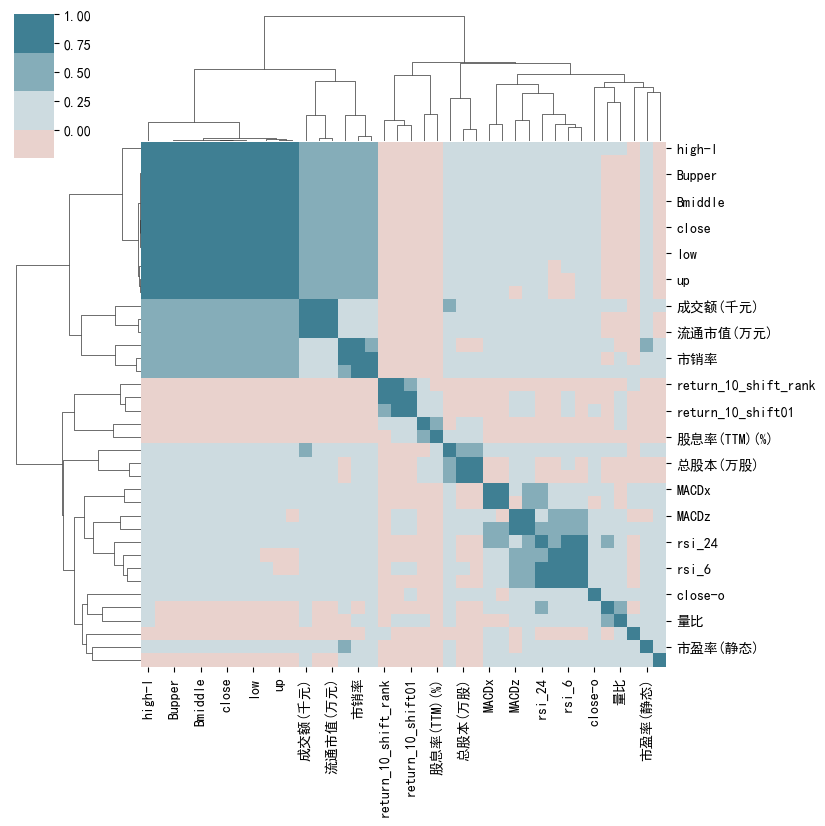

In [19]:
sns.clustermap(s_x.corr(), cmap=sns.diverging_palette(h_neg=20, h_pos=220), center=0)
plt.gcf().set_size_inches((8, 8))

In [20]:
len(s_x)

135425

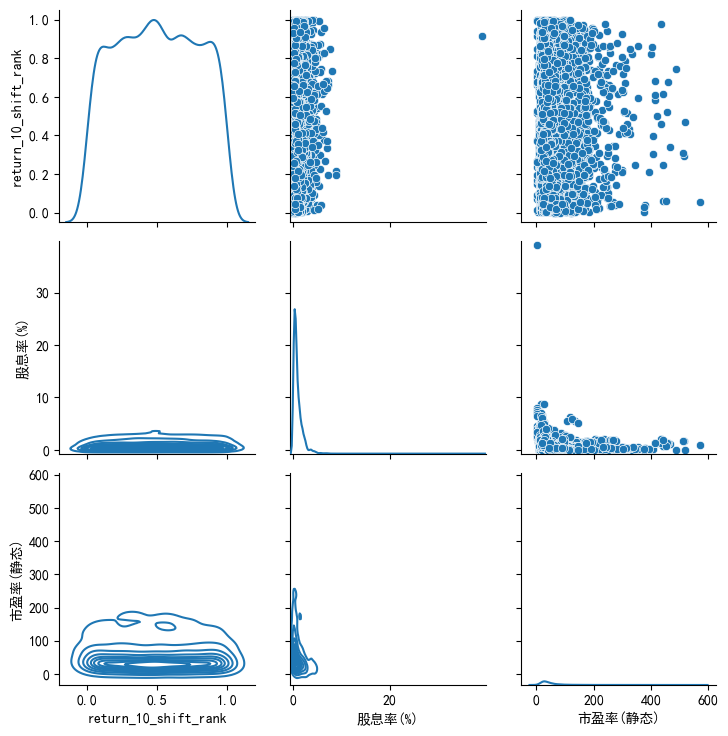

In [16]:
g = sns.PairGrid(s_x.sample(frac=0.05),vars=['return_10_shift_rank','股息率(%)','市盈率(静态)'])
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot)

### 分类分析

In [11]:
s_x.columns

Index(['open', 'high', 'low', 'close', 'volume', '成交额(千元)', '换手率(%)', '量比',
       '市盈率(静态)', '市盈率(TTM)', '市盈率(动态)', '市净率', '市销率', '市销率(TTM)', '股息率(%)',
       '股息率(TTM)(%)', '总股本(万股)', '流通股本(万股)', '总市值(万元)', '流通市值(万元)', 'b_high',
       'b_low', 'MACD_x', 'MACD_y', 'MACD_z', 'dong10', 'rsi_6', 'rsi_24',
       'up', 'down', 'return_30', 'return_5', 'return_10', 'return_10_shift',
       'close-o', 'high-l', 'return_10_shift_01', 'return_10_shift_rank'],
      dtype='object')

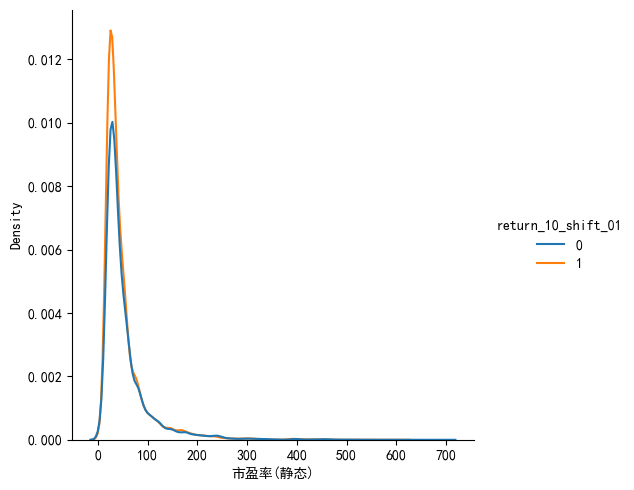

In [13]:
plot = sns.displot(s_x,x='市盈率(静态)',kind="kde",color='b',hue="return_10_shift_01")

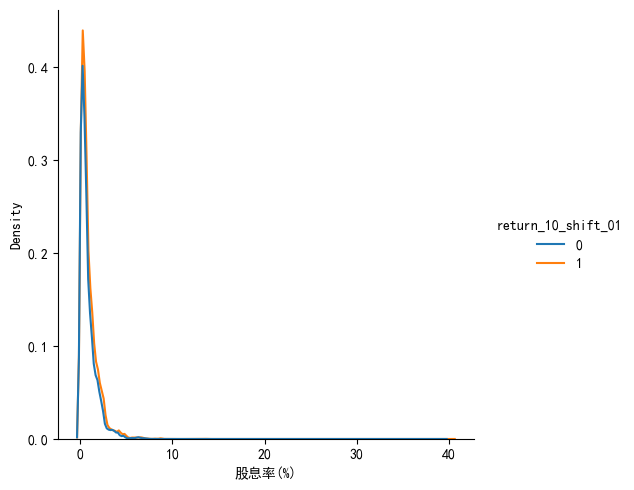

In [14]:
plot = sns.displot(s_x,x='股息率(%)',kind="kde",color='b',hue="return_10_shift_01")

<Axes: xlabel='return_10_shift_rank', ylabel='Proportion'>

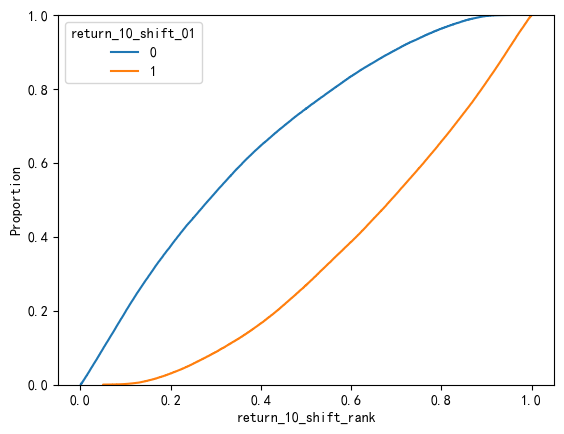

In [17]:
sns.ecdfplot(data=s_x, x="return_10_shift_rank", hue="return_10_shift_01")

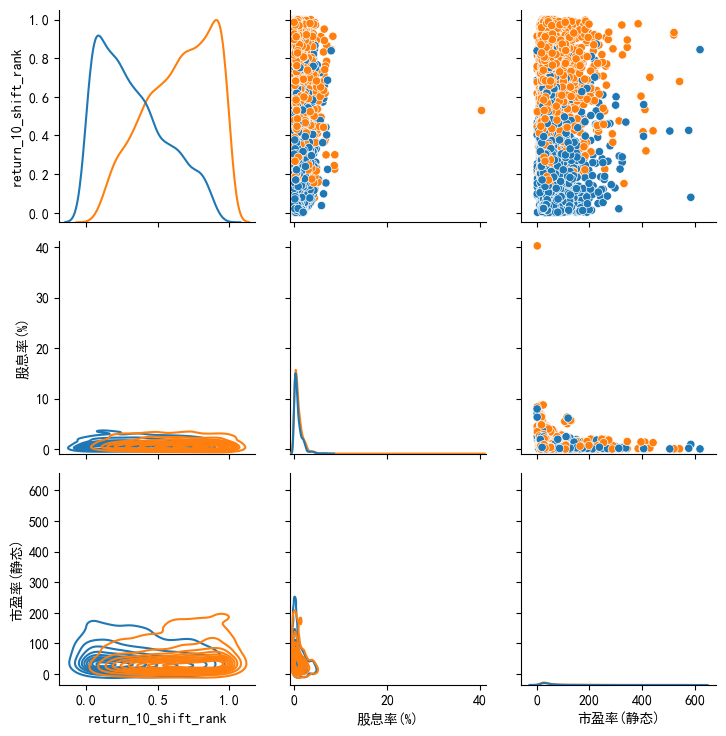

In [15]:
g = sns.PairGrid(s_x.sample(frac=0.05),vars=['return_10_shift_rank','股息率(%)','市盈率(静态)'],hue="return_10_shift_01")
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot)

In [3]:
stock_daily=read_hq()

In [4]:
start=datetime(2018,1,2)
end=datetime(2023,2,10)
stock_list=["003002.SZ","003003.SZ","300001.SZ"]
buy_date={"2020-09-22":["003002.SZ","003003.SZ"]}
sell_date={"2023-02-02":["003002.SZ","003003.SZ"]}
stock_daily_part=stock_daily[(stock_daily["date"]>=start)&(stock_daily["date"]<=end)].copy()

In [5]:
result=huice_run_num(start,end,buy_date,sell_date,stock_daily_part,stock_list,my_strategy_date_2)

2018-01-02 2023-02-10
初始资金: 1000000.00
2020-09-23, 买入003002.SZ, 成交量38006，成交价13.02
2020-09-23, 买入003003.SZ, 成交量27075，成交价18.28
2023-02-03, 卖出003002.SZ, 成交量-38006，成交价20.89
2023-02-03, 卖出003003.SZ, 成交量-27075，成交价12.09
最终资金: 1127333.06
夏普比率: OrderedDict([('sharperatio', 0.13881751787754126)])
回撤指标: AutoOrderedDict([('len', 58), ('drawdown', 8.112109741974255), ('moneydown', 99523.99033479998), ('max', AutoOrderedDict([('len', 455), ('drawdown', 47.60672029972452), ('moneydown', 563812.145)]))])


<Axes: >

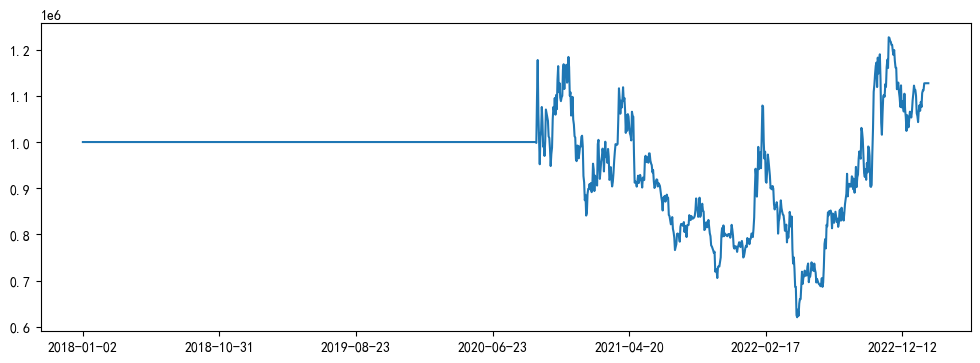

In [6]:
cash_value=pd.Series(result)
cash_value.plot(figsize=(12,4))

In [7]:
index_zh_a_hist_df = ak.index_zh_a_hist(symbol="000300", period="daily", start_date="20180222", end_date="20230210")
index_zh_a_hist_df.set_index("日期",inplace=True)
index_time=index_zh_a_hist_df["收盘"][start.date().isoformat():end.date().isoformat()]

<Axes: xlabel='日期'>

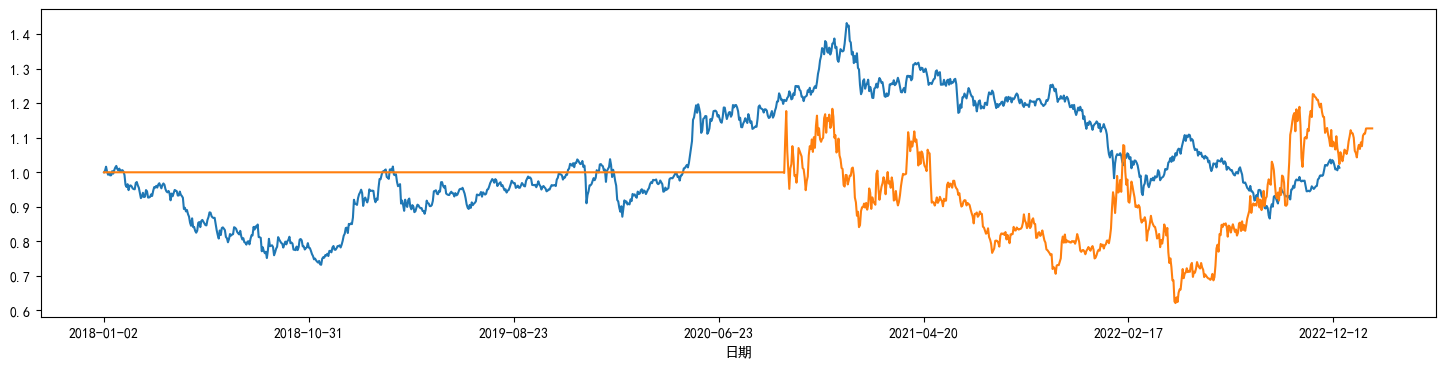

In [8]:
index_time_scale=index_time/index_time.iloc[0]
index_time_scale.plot(figsize=(18,4))
cash_value=pd.Series(result)/1000000
cash_value.plot()

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 

#回归的评价 https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

#分类的评价 https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [41]:
clf.feature_importances_
clf.predict(x2)
z1=clf.predict_proba(x2)
pd.Series(z1[:,1])

array([0.26826088, 0.73173912])

In [42]:
period=30
top_n=5
time_id=pd.Series(stock_daily.date.unique()).sort_values().tolist()
buy_date={}
sell_date={}
postion=set([])
stock_list=set([])
for i in range(0,len(time_id),30):
    stock_chi=stock_daily[(stock_daily["date"]==time_id[i+1])&(stock_daily["open"]!=stock_daily["close"])]["股票代码"].tolist()
    stock_onedate=stock_daily[(stock_daily["date"]==time_id[i])&stock_daily["股票代码"].isin(stock_chi)][["股票代码",'市盈率(静态)','总市值(万元)']].dropna()
    xy_s_x_s=stock_onedate[['市盈率(静态)','总市值(万元)']].values
    stock_onedate["score"]=clf.predict_proba(xy_s_x_s)[:,1]
    buy_list=stock_onedate.sort_values("score").tail(5)["股票代码"].tolist()

    buy_date.update({time_id[i].date().isoformat():buy_list})
    sell_list=list(postion-set(buy_list))
    sell_date.update({time_id[i].date().isoformat():sell_list})
    postion=set(buy_list)
    stock_list=stock_list|set(buy_list)
stock_list=list(stock_list)

In [43]:
start=datetime(2018,1,2)
end=datetime(2023,2,10)
stock_daily_part=stock_daily[(stock_daily["date"]>=start)&(stock_daily["date"]<=end)].copy()
result=huice_run_num(start,end,buy_date,sell_date,stock_daily_part,stock_list,my_strategy_date_2)

2018-01-02 2023-02-10
初始资金: 1000000.00
2018-01-03, 买入300214.SZ, 成交量11262，成交价16.30
2018-01-03, 买入300489.SZ, 成交量4459，成交价40.54
2018-01-03, 买入300387.SZ, 成交量5441，成交价33.16
2018-01-03, 买入300280.SZ, 成交量4950，成交价36.37
2018-01-03, 买入300354.SZ, 成交量4436，成交价40.60
2018-02-14, 卖出300280.SZ, 成交量-4950，成交价30.32
2018-02-14, 卖出300387.SZ, 成交量-5441，成交价30.16
2018-02-14, 卖出300214.SZ, 成交量-11262，成交价15.54
2018-02-14, 买入300489.SZ, 成交量630，成交价31.56
2018-02-14, 买入300321.SZ, 成交量4688，成交价33.55
2018-02-14, 买入300092.SZ, 成交量9042，成交价17.58
2018-02-14, 买入300062.SZ, 成交量6780，成交价22.96
2018-02-14, 买入300354.SZ, 成交量503，成交价31.57
2018-04-04, 卖出300092.SZ, 成交量-9042，成交价19.34
2018-04-04, 卖出300489.SZ, 成交量-5089，成交价35.69
2018-04-04, 卖出300062.SZ, 成交量-6780，成交价26.17
2018-04-04, 买入300404.SZ, 成交量4035，成交价44.38
2018-04-04, 卖出300354.SZ, 成交量-689，成交价44.34
2018-04-04, 买入300405.SZ, 成交量7889，成交价22.35
2018-04-04, 买入300321.SZ, 成交量139，成交价36.82
2018-04-04, 买入300218.SZ, 成交量10570，成交价16.50
2018-05-22, 卖出300404.SZ, 成交量-4035，成交价44.20
2018-05-22, 卖出300218.SZ, 成交量-1

In [46]:
xy=stock_daily[['市盈率(静态)','总市值(万元)',"return_30_shift30_rank"]].dropna()
xy_s=xy.sample(frac=0.4)
xy_s_x=xy_s[['市盈率(静态)','总市值(万元)']].values
xy_s_y=xy_s["return_30_shift30_rank"].values
x1,x2,y1,y2=train_test_split(xy_s_x,xy_s_y,test_size=0.7)#分割数据出训练集与测试集，0.7是两者行数的比例
clf = GradientBoostingRegressor()
clf = clf.fit(x1,y1)

In [60]:
r2_score(y2,clf.predict(x2))

0.011667212335054744

In [61]:
mean_absolute_error(y2,clf.predict(x2))

0.1310599815117247

In [62]:
period=30
top_n=5
time_id=pd.Series(stock_daily.date.unique()).sort_values().tolist()
buy_date={}
sell_date={}
postion=set([])
stock_list=set([])
for i in range(0,len(time_id),30):
    stock_chi=stock_daily[(stock_daily["date"]==time_id[i+1])&(stock_daily["open"]!=stock_daily["close"])]["股票代码"].tolist()
    stock_onedate=stock_daily[(stock_daily["date"]==time_id[i])&stock_daily["股票代码"].isin(stock_chi)][["股票代码",'市盈率(静态)','总市值(万元)']].dropna()
    xy_s_x=stock_onedate[['市盈率(静态)','总市值(万元)']].values
    stock_onedate["score"]=clf.predict(xy_s_x)
    buy_list=stock_onedate.sort_values("score").tail(5)["股票代码"].tolist()

    buy_date.update({time_id[i].date().isoformat():buy_list})
    sell_list=list(postion-set(buy_list))
    sell_date.update({time_id[i].date().isoformat():sell_list})
    postion=set(buy_list)
    stock_list=stock_list|set(buy_list)
stock_list=list(stock_list)

In [63]:
start=datetime(2018,1,2)
end=datetime(2023,2,10)
stock_daily_part=stock_daily[(stock_daily["date"]>=start)&(stock_daily["date"]<=end)].copy()
result=huice_run_num(start,end,buy_date,sell_date,stock_daily_part,stock_list,my_strategy_date_2)

2018-01-02 2023-02-10
初始资金: 1000000.00
2018-01-03, 买入300214.SZ, 成交量11262，成交价16.30
2018-01-03, 买入300305.SZ, 成交量6214，成交价28.97
2018-01-03, 买入300354.SZ, 成交量4436，成交价40.60
2018-01-03, 买入300387.SZ, 成交量5441，成交价33.16
2018-01-03, 买入300489.SZ, 成交量4459，成交价40.54
2018-02-14, 卖出300489.SZ, 成交量-4459，成交价31.56
2018-02-14, 卖出300387.SZ, 成交量-5441，成交价30.16
2018-02-14, 卖出300305.SZ, 成交量-6214，成交价24.73
2018-02-14, 卖出300214.SZ, 成交量-11262，成交价15.54
2018-02-14, 买入300218.SZ, 成交量10242，成交价15.17
2018-02-14, 买入300573.SZ, 成交量7793，成交价19.97
2018-02-14, 买入300220.SZ, 成交量3524，成交价43.67
2018-02-14, 买入300354.SZ, 成交量481，成交价31.57
2018-02-14, 买入300404.SZ, 成交量5692，成交价27.23
2018-04-04, 卖出300220.SZ, 成交量-3524，成交价52.17
2018-04-04, 卖出300354.SZ, 成交量-4917，成交价44.34
2018-04-04, 卖出300573.SZ, 成交量-7793，成交价24.92
2018-04-04, 买入300551.SZ, 成交量7855，成交价24.76
2018-04-04, 买入300443.SZ, 成交量3370，成交价57.84
2018-04-04, 买入300218.SZ, 成交量1458，成交价16.50
2018-04-04, 买入300321.SZ, 成交量5343，成交价36.82
2018-04-04, 卖出300404.SZ, 成交量-1224，成交价44.38
2018-05-22, 卖出300551.SZ, 成交

In [75]:
mean_absolute_error(y2,clf.predict(x2))

0.24700841690603842

automl 自动化机器学习

https://cloud.tencent.com/developer/article/2069069